In [19]:
from typing import (
    List,
    Tuple,
    Dict,
)

import os
import sys
import csv

import altair as alt
import pandas as pd

In [17]:
EXPERIMENT_FOLDER = 'experiment_data/keyword_matching'
EXPERIMENT_FILES = [f for f in os.listdir(EXPERIMENT_FOLDER)]
METRICS = {
    'active valid/ADR/f1': 'F1',
    'active valid/ADR/precision': 'Precession',
    'active valid/ADR/recall': 'Recall',
}

DataDef = List[
    Dict[str, object]
]

In [69]:
def parse_file(file_name: str, experiment_tag: str) -> DataDef:
    output = []
    with open(file_name, 'r') as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
            # tag, value, step
            metric_name, metric_val, step = row
            if metric_name not in METRICS:
                continue
            output.append({
                'metric_name': METRICS[metric_name],
                'metric_val': round(float(metric_val), 2),
                'step': float(step),
                'tag': experiment_tag,
            })
    return output

data = []
for file in EXPERIMENT_FILES:
    if file.startswith('.'):
        print(f'skipping: {file}...')
        continue
    file_res = parse_file(os.path.join(EXPERIMENT_FOLDER, file), file[:-len('.csv')])
    print(f'Parsed: {file}')
    data.extend(file_res)
data_frame = pd.DataFrame(data)
data_frame.head(2)

Parsed: no_weak.csv
Parsed: weak_0.1.csv
Parsed: weak_0.01.csv
Parsed: weak_0.001.csv
skipping: .ipynb_checkpoints...
Parsed: weak_1.csv


,metric_name,metric_val,step,tag
0,Precession,0.48,1.0,no_weak
1,Precession,0.69,6.0,no_weak


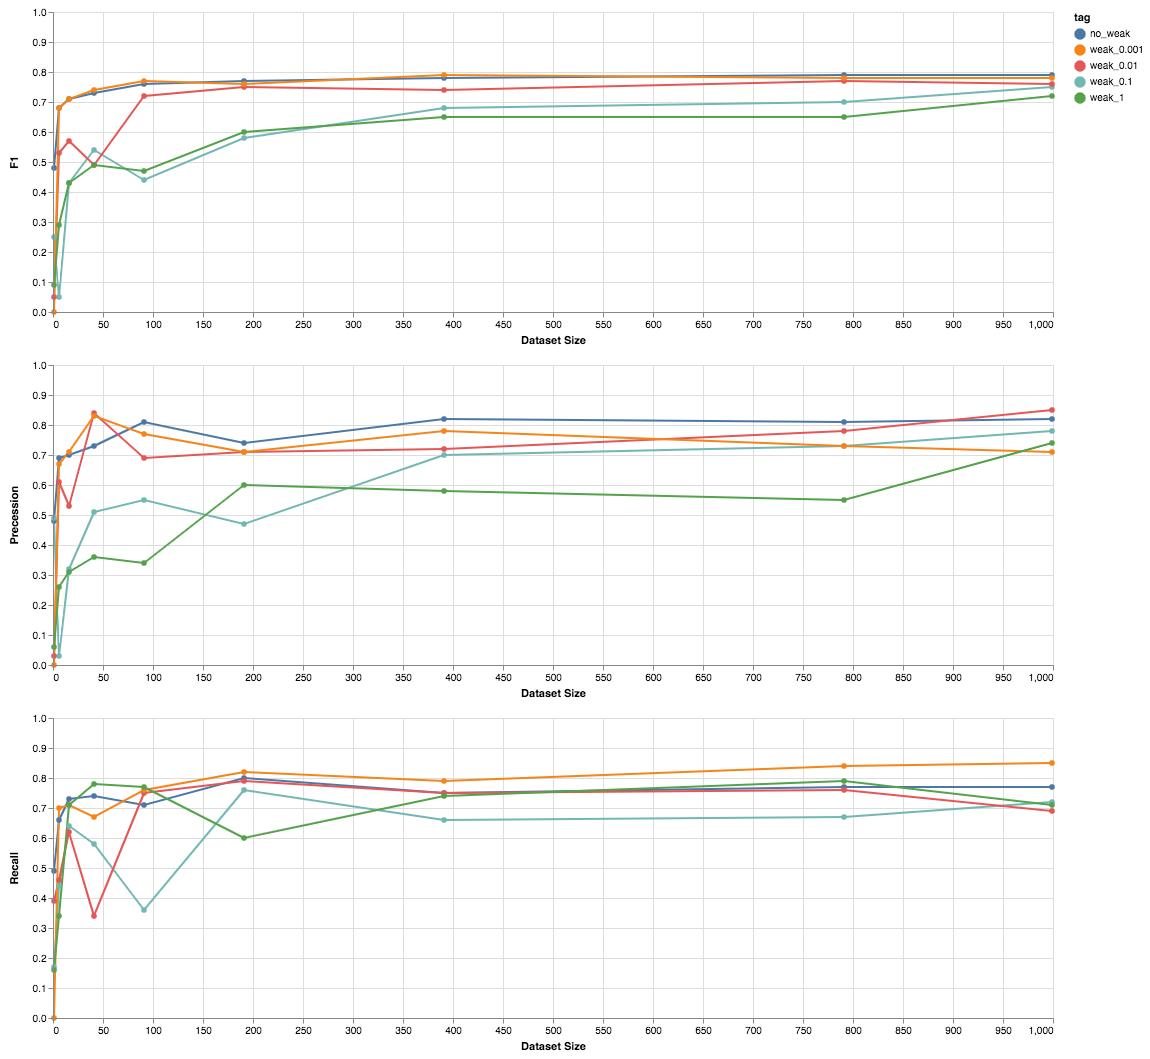

In [74]:
METRIC='F1'

def metric_graph(data_frame: pd.DataFrame, metric: str) -> alt.Chart:
    chart = alt.Chart(data_frame).mark_line(point=True).encode(
        x=alt.X('step', title='Dataset Size'),
        y=alt.Y('metric_val', title=metric, scale=alt.Scale(domain=[0, 1])),
        color='tag',
    ).transform_filter(alt.datum.metric_name == metric)

    # Create a selection that chooses the nearest point & selects based on x-value
    nearest = alt.selection(type='single', nearest=True, on='mouseover',
                            fields=['step'], empty='none')
    
    # Transparent selectors across the chart. This is what tells us
    # the x-value of the cursor
    selectors = alt.Chart().mark_point().encode(
        x='step:Q',
        opacity=alt.value(0),
    ).add_selection(
        nearest
    )

    # Draw points on the line, and highlight based on selection
    points = chart.mark_point().encode(
        opacity=alt.condition(nearest, alt.value(1), alt.value(0))
    )

    # Draw text labels near the points, and highlight based on selection
    text = chart.mark_text(align='left', dx=5, dy=-5).encode(
        text=alt.condition(nearest, 'metric_val:Q', alt.value(' '))
    )

    # Draw a rule at the location of the selection
    rules = alt.Chart().mark_rule(color='gray').encode(
        x='step:Q',
    ).transform_filter(
        nearest
    )
    
    #return alt.layer(chart, selectors, points, rules, text,
     #     data=data_frame, width=600, height=300)
    return chart.properties(width=1000)

res = [metric_graph(data_frame, metric) for metric in METRICS.values()]
(res[0] & res[1] & res[2])

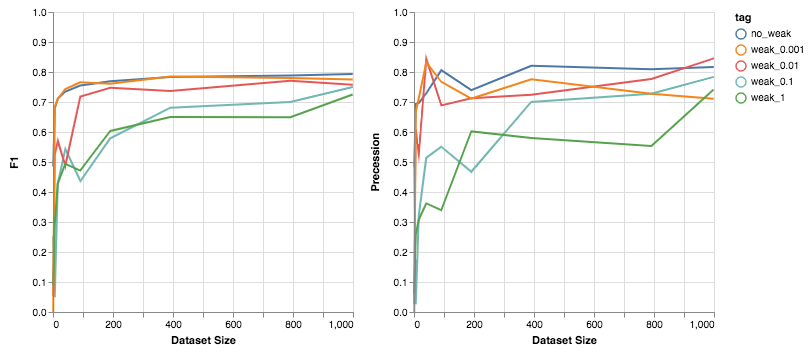

In [65]:
def interactive_experiment(data_frame: pd.DataFrame, metric: str) -> alt.Chart:
    pts = alt.selection(type="interval", encodings=["x"])

    # left panel: line chart of F1 score
    f1 = alt.Chart().mark_line().encode(
        x=alt.X('step', title='Dataset Size'),
        y=alt.Y('metric_val', title=metric, scale=alt.Scale(domain=[0, 1])),
        color='tag',
    ).transform_filter(alt.datum.metric_name == 'F1').properties(
        selection=pts,
        width=300,
        height=300
    )

    # right panel: histogram
    prec = alt.Chart().mark_line().encode(
        x=alt.X('step', title='Dataset Size'),
        y=alt.Y('metric_val', title='Precession', scale=alt.Scale(domain=[0, 1])),
        color='tag',
    ).transform_filter(alt.datum.metric_name == 'Precession').transform_filter(
        pts.ref()
    ).properties(
        width=300,
        height=300
    )

    # build the chart:
    return alt.hconcat(
        f1,
        prec,
        data=data_frame
    )
# .transform_bin(
#         "mbin",
#         field="m",
#         bin=alt.Bin(maxbins=20)
#     )
interactive_experiment(data_frame, 'F1')

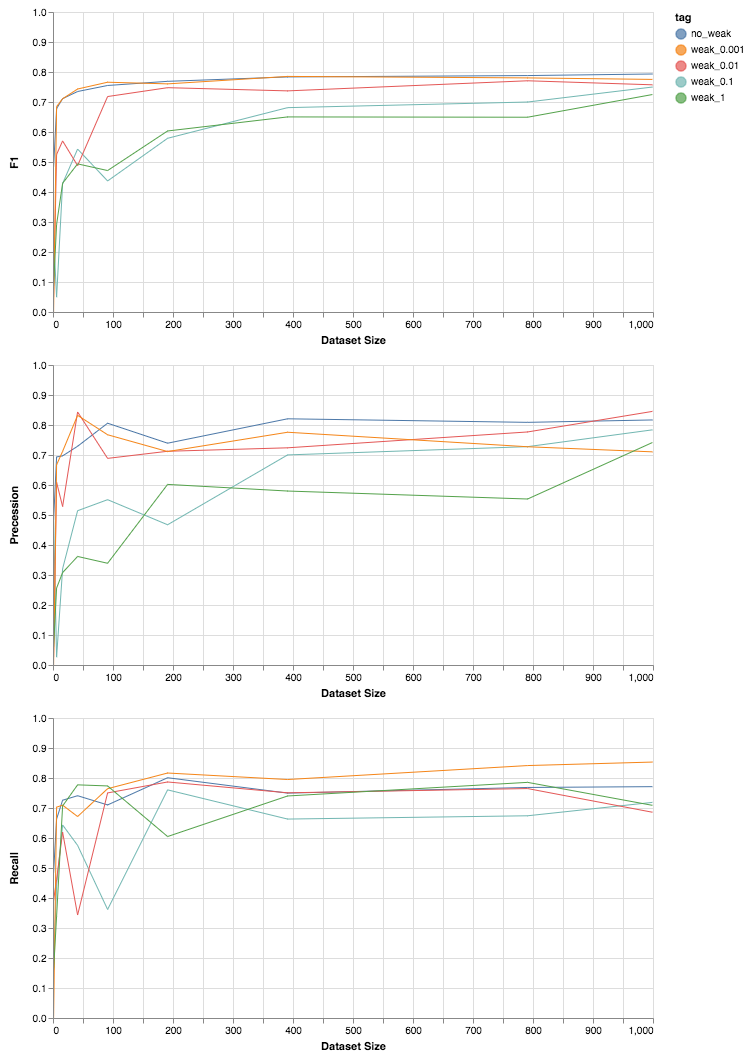

In [66]:
def highlightable_line(data_frame: pd.DataFrame, metric: str) -> alt.Chart:
    highlight = alt.selection(type='single', on='mouseover',
                          fields=['tag'], nearest=True)

    chart = alt.Chart(data_frame).mark_line().encode(
        x=alt.X('step', title='Dataset Size'),
        y=alt.Y('metric_val', title=metric, scale=alt.Scale(domain=[0, 1])),
        color='tag',
    ).transform_filter(alt.datum.metric_name == metric)

    points = chart.mark_circle().encode(
        opacity=alt.value(0)
    ).add_selection(
        highlight
    ).properties(
        width=600
    )

    lines = chart.mark_line().encode(
        size=alt.condition(~highlight, alt.value(1), alt.value(3))
    )
    
    return points + lines
res = [highlightable_line(data_frame, metric) for metric in METRICS.values()]
(res[0] & res[1] & res[2])